#### Example

This is an example of the complete process used to generate and plot the data for the paper 'Compare the Pair: Rotated vs. Unrotated Surface Codes at Equal Logical Error Rates'. 

##### Requirements

In [218]:
# pip install stim      # Stim: a stabiliser circuit simulator

In [219]:
# pip install sinter==1.13.0 

In [220]:
import sinter
import stim
import numpy as np

import os
import sys

import shutil
import subprocess

sys.path.insert(0, 'functions') 
import oscAntgencircuitv2 as oscant
import morefuncs as morefuncs
import com_funcs5 as funcs

# Update with any changes to these files:
from importlib import reload
reload(morefuncs)
reload(funcs)
reload(oscant);

##### Generate surface code circuits:

In [227]:
reload(morefuncs)

# Delete existing circuits (so as not to simulate them)
shutil.rmtree('circuits', ignore_errors=True)

# Make directories to store new circuits:
for path in ['SI/x', 'SI/z', 'SD/x', 'SD/z']:
    os.makedirs(f'circuits/{path}', exist_ok=True)


# Generate circuits:

# x = (...) and z = (...) below define the CNOT order for x and z type stabilisers. E.g. order 10231203 avoids hook errors in the rotated code and is a worst-case CNOT order for the unrotated code if doing memory Z experiments (worst-case taken to be most applicable to all states). 

# p_values = [0.0005,0.0007,0.001,0.002,0.003,0.004,0.0049,0.005,0.0051,0.0052,0.0055,0.0056,0.0057,0.0058,0.006,0.007,0.008,0.009,0.01] 
p_values = [0.0033]


for ro in ['unro']:#,'ro']:
    
    if ro == 'unro':
        x = (1,0,2,3)
        z = (1,2,0,3)
        unro_CNOT_order = int(''.join(map(str, x + z)))
        ds = range(2,18)

    
    elif ro == 'ro':
        x = (3,2,0,1) # x hook error in rotated code if last two x-type CNOT's are 12, 21, 03 or 30
        z = (3,0,2,1) # z hook error in rotated code if last two z-type CNOT's are 01, 10, 23 or 32
        ro_CNOT_order = int(''.join(map(str, x + z)))
        ds = range(2,23)

    for p in p_values:

        for d in ds:
            for b in 'xz':
                
                thecircuit = oscant.generate_circuit(
                    f"surface_code:{ro}tated_memory_{b}",
                    rounds=3*d, 
                    distance=d, 
                    after_clifford_depolarization=p,
                    after_reset_flip_probability=p,
                    before_measure_flip_probability=p, 
                    before_round_data_depolarization=p,
                    x_cnot_order = x,
                    z_cnot_order = z,
                    exclude_other_basis_detectors = True, # no need to add their detections to the graph which will be given to PyMatching as it is not a correlated decoder (still perform the opposite basis' stabiliser measurements though)
                )

                morefuncs.add_idling_errors_and_save_circuit(thecircuit, b, d, p, ro, x, z) # saves circuit in circuits/SD (standard depolarising)

                # # Optional: Generate CXSI (SI with CX gates) p_values model circuits too by adjusting error probs. of SD circuits then saving a separate circuit:

                thecircuit = morefuncs.make_CXSI_circuit(b, d, p, ro, x, z)

##### Optional: visualise a circuit

In [222]:
# noise_model = 'SD' # choices are SD (standard depolarising) or SI (superconducting inspired) -- both circuit-level.
# d = 3 # distance 
# p = 0.0005 # physical error rate
# basis = 'x' # choices are x (preserve logical plus state) or z (preserve logical zero state)
# rot = 'ro' # choices are 'ro' or 'unro' for rotated or unrotated surface code
# order = 32013021 # CNOT order as an integer.

# circuit_path = f"circuits/{noise_model}/{basis}/d={d},p={p},b={basis},r=3d,ro={rot},o={order},idl=y.stim"
# thecircuit = stim.Circuit.from_file(circuit_path) 

# print(repr(thecircuit))
# display(thecircuit.without_noise().diagram("detslice-with-ops-svg", tick=range(0,4))) # note only one stab. type detecting region appears if exlude_other_basis_detectors above is True, though the operations will still be done to measure that stabiliser
# display(thecircuit.without_noise().diagram("detslice-svg", tick=range(0,4)))
# display(thecircuit.without_noise().diagram('timeline-svg'))
# display(thecircuit.diagram('timeline-svg'))
# display(thecircuit.diagram('timeline-svg'))



##### Sample the circuits:

In [223]:
%%bash

noise_model="SD" # either SD (standard depolarising) or SI (superconducting-inspired) noise

rm collected_stats/example_stats.csv 2>/dev/null


sinter collect \
    --processes 4 \
    --circuits circuits/$noise_model/*/*.stim \
    --metadata_func "sinter.comma_separated_key_values(path)" \
    --decoders pymatching \
    --max_shots 1 \
    --max_errors 1 \
    --save_resume_filepath collected_stats/example_stats.csv

Starting 4 workers...
Finding work...
8 cases left:
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=13,idl=y,o=10231203,p=0.008,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=13,idl=y,o=10231203,p=0.009,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=15,idl=y,o=10231203,p=0.008,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=15,idl=y,o=10231203,p=0.009,r=3d,ro=unro}
8 cases left:
    pymatching processes=1  ~core_mins_left=None    shots_left=1        errors_left=1       {b=x,d=13,idl=y,o=10231203,p=0.008,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=13,idl=y,o=10231203,p=0.009,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=15,idl=y,o=10231203,p=0.008,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=15

In [224]:
# # # combine and print the stats (optional):
result = subprocess.run(
    ['sinter', 'combine', 'collected_stats/example_stats.csv'], 
    check=True, text=True, capture_output=True)
print(result.stdout)
print(result.stderr)

     shots,    errors,  discards, seconds,decoder,strong_id,json_metadata,custom_counts
       100,        54,         0,    2.33,pymatching,4135fb35314e3476d450e8e3a8c4ae0c473b2b724e61039b465ec94fc1e4fc60,"{""b"":""x"",""d"":13,""idl"":""y"",""o"":10231203,""p"":0.008,""r"":""3d"",""ro"":""unro""}",
       100,        54,         0,    2.38,pymatching,1aa64d859248b72f58c8574d3be61a0ed3f5059ec2c983dd9286a9663822dc8b,"{""b"":""x"",""d"":13,""idl"":""y"",""o"":10231203,""p"":0.009,""r"":""3d"",""ro"":""unro""}",
       100,        47,         0,    2.71,pymatching,187826fa29e02d5583b08e8777e99908a60529b8dd2cc056b4db9e658ccbaf84,"{""b"":""x"",""d"":15,""idl"":""y"",""o"":10231203,""p"":0.008,""r"":""3d"",""ro"":""unro""}",
       100,        45,         0,    2.93,pymatching,d25ac0913f8d46adeb2787eb7297dd3f134ca27071ac73777b243338ece01b39,"{""b"":""x"",""d"":15,""idl"":""y"",""o"":10231203,""p"":0.009,""r"":""3d"",""ro"":""unro""}",
       100,        52,         0,    1.00,pymatching,375

##### Threshold plots: $p_L$ vs. $p$

ValueError: min() arg is an empty sequence

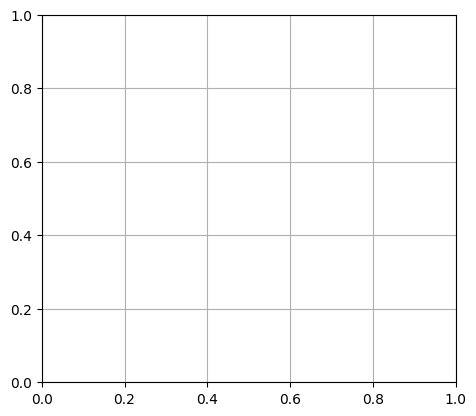

In [225]:
# python:
reload(funcs)

mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')

funcs.plot_thresholds(mylist, ro_CNOT_order, unro_CNOT_order, ylims = [None, None]) # note different y-axis scalings

##### Fit to scaling function $p_L = \alpha ( p / \beta)^{\gamma d - \delta}$

In [ ]:
reload(funcs)
distances = 'combined' # choices are 'odd', 'even' or 'combined'
b = 'z' # choices are x or z 

funcs.fit_scaling_and_plot(mylist, distances, b, ro_CNOT_order, unro_CNOT_order, minp = min(p_values), maxp = max(p_values)) 

Need at least two combined distances to perform fit. Skipping this function.


##### Plot as $p_L$ vs. $\sqrt{n}$

/home/fourmi/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/fourmi/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/fourmi/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


SystemExit: No circuits matched p=0.001,b=z,rt=unro,o=10231203 in input csv file.

/home/fourmi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


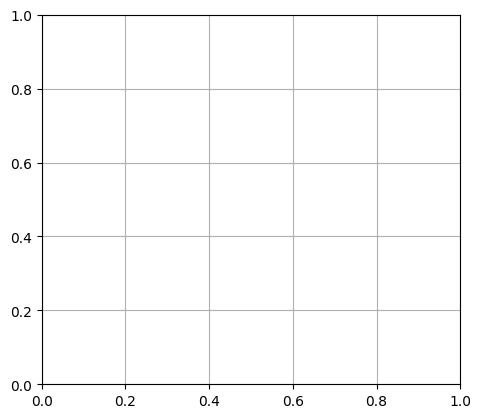

In [ ]:
reload(funcs)

b = 'z' 

mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')
# 
funcs.plot_pL_vs_qubit_count(mylist, b, ro_CNOT_order, unro_CNOT_order)

##### Plot 'teraquop' count :$\ $ the number of qubits required to reach $p_L = 10^{-12}$

In [ ]:
funcs.plot_teraquop(mylist, b, ro_CNOT_order, unro_CNOT_order, optional_plot = False)

<IPython.core.display.Math object>

ZeroDivisionError: division by zero

##### Plot ratios of qubit counts vs. $p_L$

This is the projected number of qubits used by the rotated surface code divided by the number of qubits used by the unrotated surface code to achieve the same $p_L$

In [ ]:
reload(funcs)

funcs.plot_ratio(mylist, b, ro_CNOT_order, unro_CNOT_order)

##### Memory time vs. $\sqrt{n}$

This is a reformulation of the $p_L$ vs. $\sqrt{n}$ plots above, converting the $p_L$ per $d$ rounds to be the length of time (assuming one stabiliser measurement cycle take a microsecond) before $p_L$ over the entire shot of the memory experiment equals $p$.

In [ ]:
funcs.plot_memory_times(mylist, b, ro_CNOT_order, unro_CNOT_order)